# LogPolar images reconstruction tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from torchvision import datasets, models, transforms
from utils import view_data
from typing import List, Tuple

In [4]:
from easydict import EasyDict as edict
import pickle

In [261]:
args = edict({})
args.image_size = 240
args.batch_size = 5

In [8]:
transform_base =  transforms.Compose([
            transforms.Resize((int(args.image_size), int(args.image_size))),
            transforms.ToTensor(),  # Convert the image to pyTorch Tensor data type.
            ])      
    

In [11]:
#path = '/run/user/1001/gvfs/dav:host=spik.xyz,ssl=true,prefix=%2Fnc%2Fremote.php%2Fdav/files/emmanuel/JNJER_PhD/'
#path = "/envau/work/brainets/dauce.e/data/animal/"
#path = "/media/manu/Seagate Expansion Drive/"
path = "/run/user/1001/gvfs/sftp:host=bag-008-de03/envau/work/brainets/dauce.e/"
#path = "/run/user/1001/gvfs/sftp:host=192.168.0.10/media/manu/Seagate Expansion Drive/"
#path = "../data/animal/"
#image_path = "Data/animal/"
image_path='data/animal/'

image_dataset = { 'train' : datasets.ImageFolder(
                            path+image_path+'train',
                            transform=transform_base
                        ),
                  'test' : datasets.ImageFolder(
                            path+image_path+'test',
                          transform=transform_base
                        )
                }

In [12]:
num_workers = 1

dataloader = { 'train' : torch.utils.data.DataLoader(
                            image_dataset['train'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        ),
               'test' : torch.utils.data.DataLoader(
                            image_dataset['test'], batch_size=args.batch_size,
                            shuffle=True, 
                            num_workers=num_workers,
                        )
             }

In [18]:
def donut_LogPolarGrid(a, b, base=2): 
    # Take a < b < 0 : "donut" image between r = 2**a and r = 2**b < 1
    rs = torch.logspace(a, b, args.image_size, base = base)
    ts = torch.linspace(0, torch.pi*2, args.image_size)

    grid_xs = torch.outer(rs, torch.cos(ts)) 
    grid_xs = grid_xs.unsqueeze(0).unsqueeze(3)
    grid_xs = Variable(grid_xs, requires_grad=False)

    grid_ys = torch.outer(rs, torch.sin(ts)) 
    grid_ys = grid_ys.unsqueeze(0).unsqueeze(3)
    grid_ys = Variable(grid_ys,  requires_grad=False)

    grid = torch.cat((grid_xs, grid_ys), 3)

    return grid 

In [17]:
def disc_LogPolarGrid(r, base=2):
    # r is the radius of the disc in pixel space (r <= args.image_size / 2)
    rs = torch.logspace(0, np.log(r)/np.log(base), args.image_size, base = base) * 2 / args.image_size
    ts = torch.linspace(0, torch.pi*2, args.image_size)

    grid_xs = torch.outer(rs, torch.cos(ts)) 
    grid_xs = grid_xs.unsqueeze(0).unsqueeze(3)
    grid_xs = Variable(grid_xs, requires_grad=False)

    grid_ys = torch.outer(rs, torch.sin(ts)) 
    grid_ys = grid_ys.unsqueeze(0).unsqueeze(3)
    grid_ys = Variable(grid_ys,  requires_grad=False)

    grid = torch.cat((grid_xs, grid_ys), 3)

    return grid

In [252]:
from scipy.ndimage import map_coordinates
import math

def donut_LogPolar_Linear(img, a, b, o=None, r=None, output=None, order=1, cont=0, verb=False):
    # Take a < b < 0 : "donut" image between r = 2**a and r = 2**b < 1
    if r is None: r = img.shape[0]//2
    img_width = img.shape[0]
    r_ref = img.shape[0]//2
    if output is None:
        output = np.zeros((r*2, r*2, 3), dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    if o is None: o = np.array(output.shape[:2])/2 - 0.5
    out_h, out_w, col = output.shape
    ys, xs = np.mgrid[:out_h, :out_w] - o[:,None,None]    
    ys_n, xs_n = ys / r_ref, xs / r_ref
    rho = (ys_n**2+xs_n**2)**0.5
    rs =  (-np.log(2**a) + np.log(rho * 2**b)) / (np.log(2**b) - np.log(2**a)) * img_width
    if verb:
        print(r, np.min(rs), np.max(rs))
        plt.figure()
        _ = plt.hist(np.unique(rs),30)
    rho_ref = (ys**2+xs**2)**0.5
    ts = np.arccos(xs/rho_ref)
    ts[ys<0] = np.pi*2 - ts[ys<0]
    ts *= (img.shape[1]-1)/(np.pi*2)
    if verb:
        plt.figure()
        plt.imshow(rs)
        plt.imshow(rs<0, alpha=.3)
        plt.colorbar()
        plt.figure()
        plt.imshow(ts)
        plt.colorbar()
    for c in range(col):
        map_coordinates(img[:,:,c], (rs, ts), order=order, output=output[:,:,c])
        output[math.floor(o[0]),math.floor(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.floor(o[0]),math.ceil(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.ceil(o[0]),math.floor(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.ceil(o[0]),math.ceil(o[1]),c] = img[0,img.shape[0]//2,c]
    return output

In [257]:
from scipy.ndimage import map_coordinates
import math

def disc_LogPolar_Linear(img, o=None, r=None, output=None, order=1, cont=0, verb=False):
    if r is None: r = img.shape[0]//2
    img_width = img.shape[0]
    r_ref = img.shape[0]//2
    if output is None:
        output = np.zeros((r*2, r*2, 3), dtype=img.dtype)
    elif isinstance(output, tuple):
        output = np.zeros(output, dtype=img.dtype)
    if o is None: o = np.array(output.shape[:2])/2 - 0.5
    out_h, out_w, col = output.shape
    ys, xs = np.mgrid[:out_h, :out_w] - o[:,None,None]
    ys_n, xs_n = ys / r_ref, xs / r_ref
    rho = (ys_n**2+xs_n**2)**0.5
    rs = np.log2(1+rho*r) / np.log2(1+r) * img_width
    if verb:
        print(r, np.min(rs), np.max(rs))
        plt.figure()
        _ = plt.hist(np.unique(rs),30)
    rho_ref = (ys**2+xs**2)**0.5
    ts = np.arccos(xs/rho_ref)
    ts[ys<0] = np.pi*2 - ts[ys<0]
    ts *= (img.shape[1]-1)/(np.pi*2)
    if verb:
        plt.figure()
        plt.imshow(rs)
        plt.imshow(rs<0, alpha=.3)
        plt.colorbar()
        plt.figure()
        plt.imshow(ts)
        plt.colorbar()
    for c in range(col):
        map_coordinates(img[:,:,c], (rs, ts), order=order, output=output[:,:,c])
        output[math.floor(o[0]),math.floor(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.floor(o[0]),math.ceil(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.ceil(o[0]),math.floor(o[1]),c] = img[0,img.shape[0]//2,c]
        output[math.ceil(o[0]),math.ceil(o[1]),c] = img[0,img.shape[0]//2,c]
    return output

In [21]:
def view_data(data: torch.Tensor, label: torch.Tensor, n: int) -> plt.Figure:
    
    fig, axs = plt.subplots(1, n, figsize = (5*n, 5))
    for i_ax, ax in enumerate(axs):
        ax.imshow(data[i_ax, :, :, :].permute(1,2,0)) #, cmap=plt.gray())
        ax.set_title("Label = %d"%(label[i_ax].item()))
        ax.set_xticks([])
        ax.set_yticks([])
    return fig


## Original images  (240 x 240)

In [22]:
data, label = next(iter(dataloader['train']))

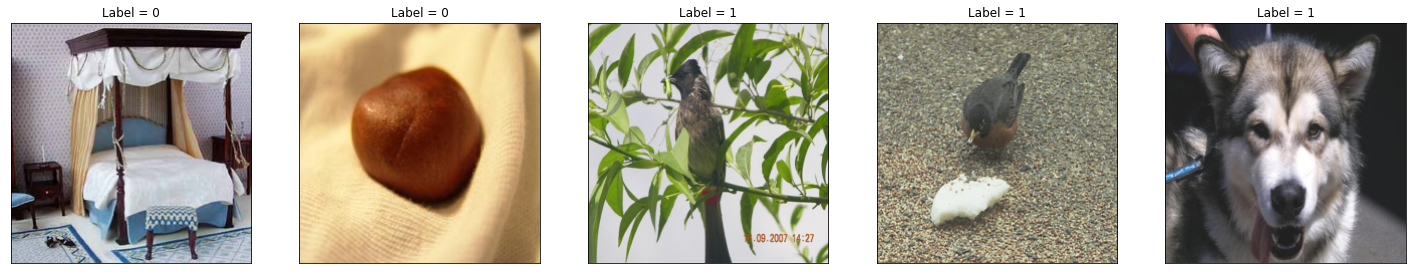

In [155]:
original = view_data(data, label, 5)

## Donut LogPolar

### Full width (r between $2^{−4}$ et $2^0$)

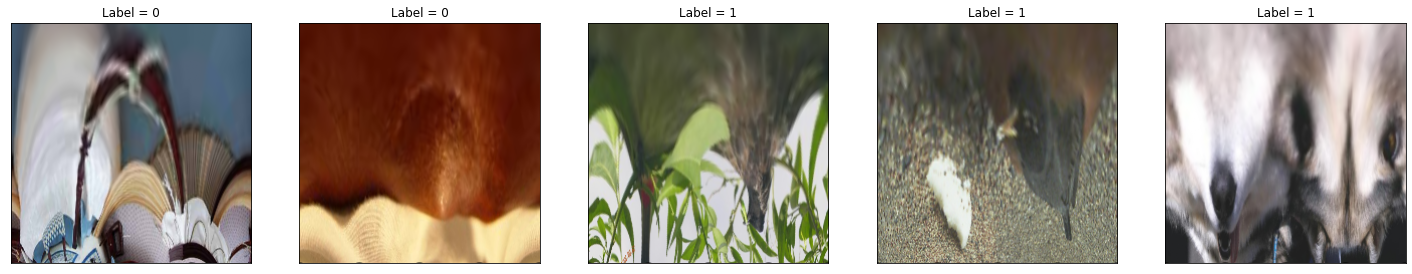

In [211]:
grid = donut_LogPolarGrid(-4, 0)
donut_log_data = torch.zeros_like(data)
for i in range(len(data)):
    donut_log_data[i] = F.grid_sample(data[i].unsqueeze(0), grid)
_ = view_data(donut_log_data, label, 5)

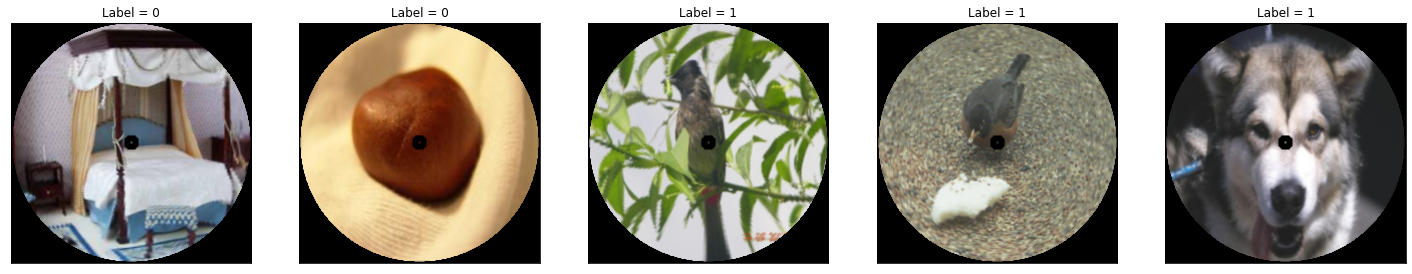

In [238]:
donut_data_rec = torch.zeros_like(data)
for i in range(len(data)):
    img = donut_log_data[i].permute(1,2,0).detach().numpy()
    img = donut_LogPolar_Linear(img, -4, 0, r=120, output=(240,240,3))
    #img = logpolar_linear(img, -4, 0, r=60, output=(240,240,3), verb=(i==0))
    donut_data_rec[i] = torch.FloatTensor(img).permute(2,0,1)
reconstructed = view_data(donut_data_rec, label, 5)

### Focal (r between $2^{-4}$ et $2^{-1}$= 0.5)

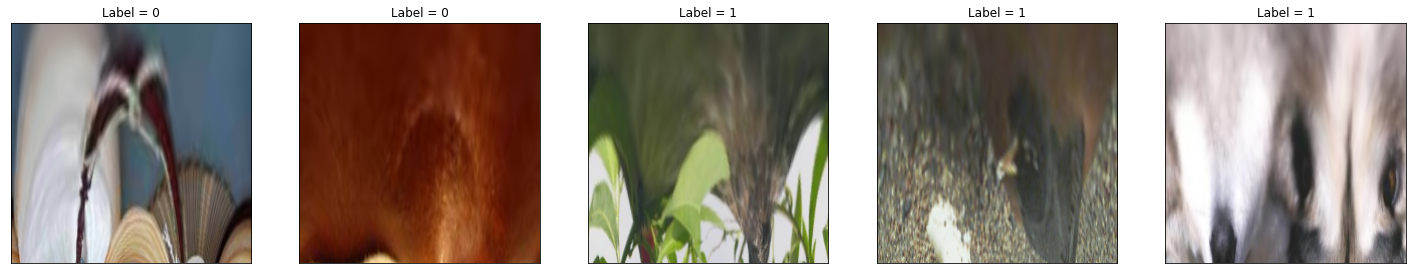

In [240]:
grid = donut_LogPolarGrid(-4, -1)
donut_log_data = torch.zeros_like(data)
for i in range(len(data)):
    donut_log_data[i] = F.grid_sample(data[i].unsqueeze(0), grid)
_ = view_data(donut_log_data, label, 5)

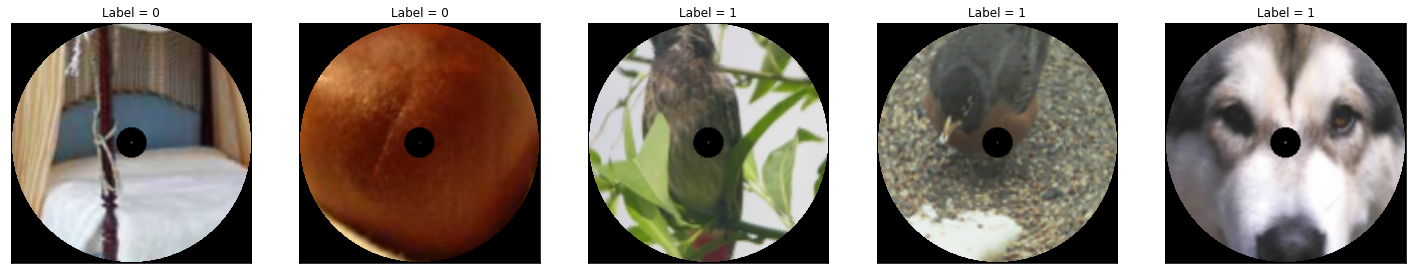

In [241]:
donut_data_rec = torch.zeros_like(data)
for i in range(len(data)):
    img = donut_log_data[i].permute(1,2,0).detach().numpy()
    img = donut_LogPolar_Linear(img, -4, -1, r=120, output=(240,240,3))
    donut_data_rec[i] = torch.FloatTensor(img).permute(2,0,1)
reconstructed = view_data(donut_data_rec, label, 5)

## Disc LogPolar

### Full width

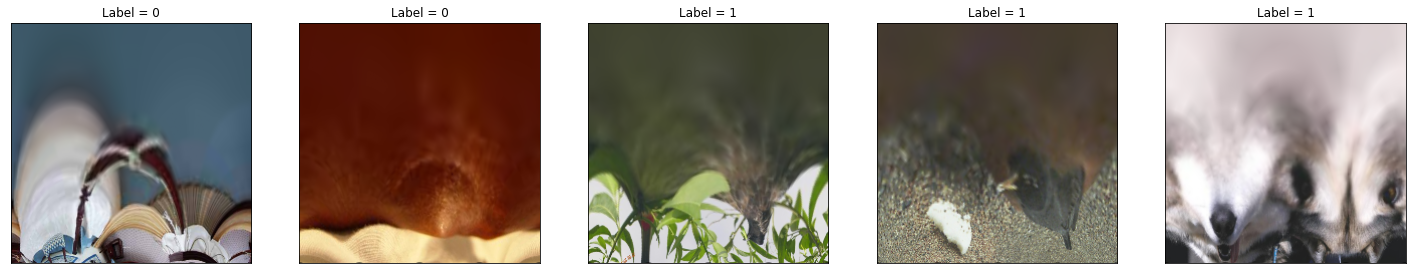

In [253]:
grid = disc_LogPolarGrid(120)
disc_log_data = torch.zeros_like(data)
for i in range(len(data)):
    disc_log_data[i] = F.grid_sample(data[i].unsqueeze(0), grid)
_ = view_data(disc_log_data, label, 5)

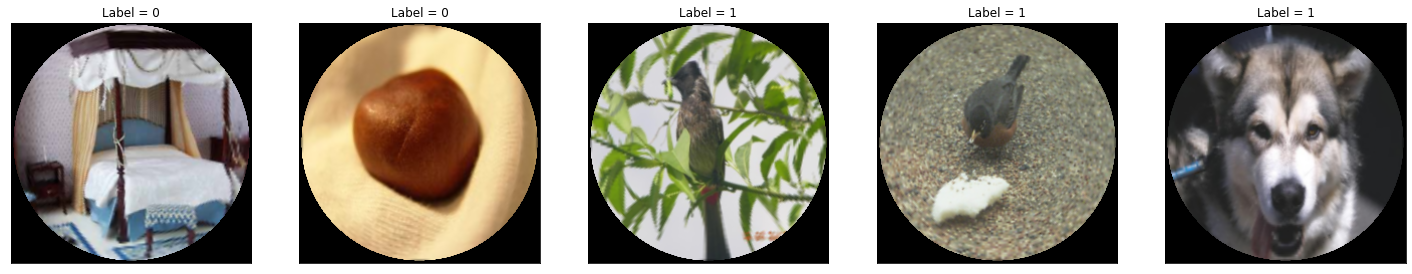

In [263]:
data_rec = torch.zeros_like(data)
for i in range(len(data)):
    img = disc_log_data[i].permute(1,2,0).detach().numpy()
    img = disc_LogPolar_Linear(img, r=120, output=(240,240,3))
    data_rec[i] = torch.FloatTensor(img).permute(2,0,1)
reconstructed = view_data(data_rec, label, 5)

### Focal (r = 0.5 => 60 pixels)

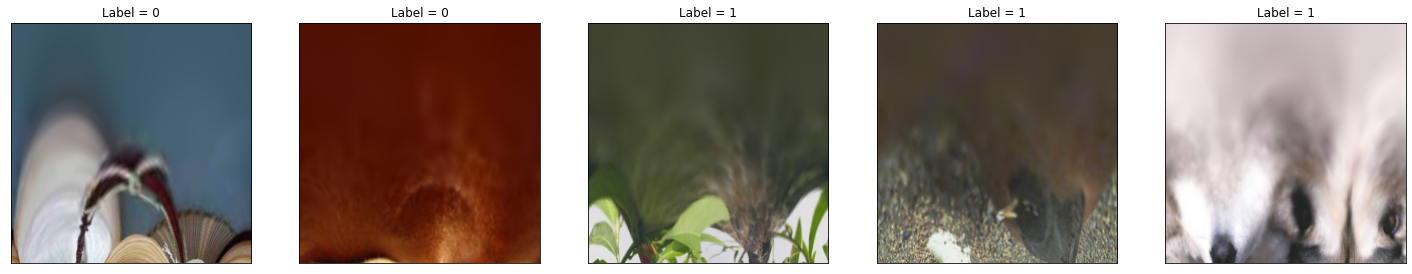

In [264]:
grid = disc_LogPolarGrid(60)
disc_log_data = torch.zeros_like(data)
for i in range(len(data)):
    disc_log_data[i] = F.grid_sample(data[i].unsqueeze(0), grid)
_ = view_data(disc_log_data, label, 5)

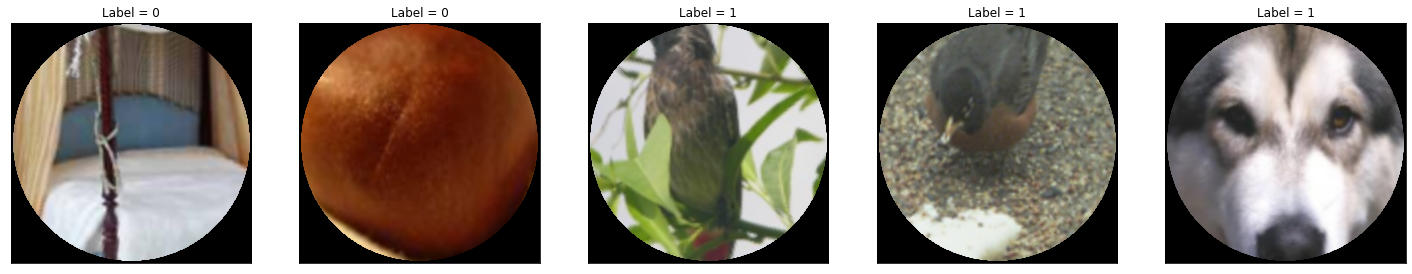

In [265]:
data_rec = torch.zeros_like(data)
for i in range(len(data)):
    img = disc_log_data[i].permute(1,2,0).detach().numpy()
    img = disc_LogPolar_Linear(img, r=60, output=(240,240,3))
    data_rec[i] = torch.FloatTensor(img).permute(2,0,1)
reconstructed = view_data(data_rec, label, 5)